## Part 1: preparing data

Load pixel data from CSV file.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random


img_size = 28
mnist_data = pd.read_csv('./mnist.csv').values
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]      # DATA: raw digits data

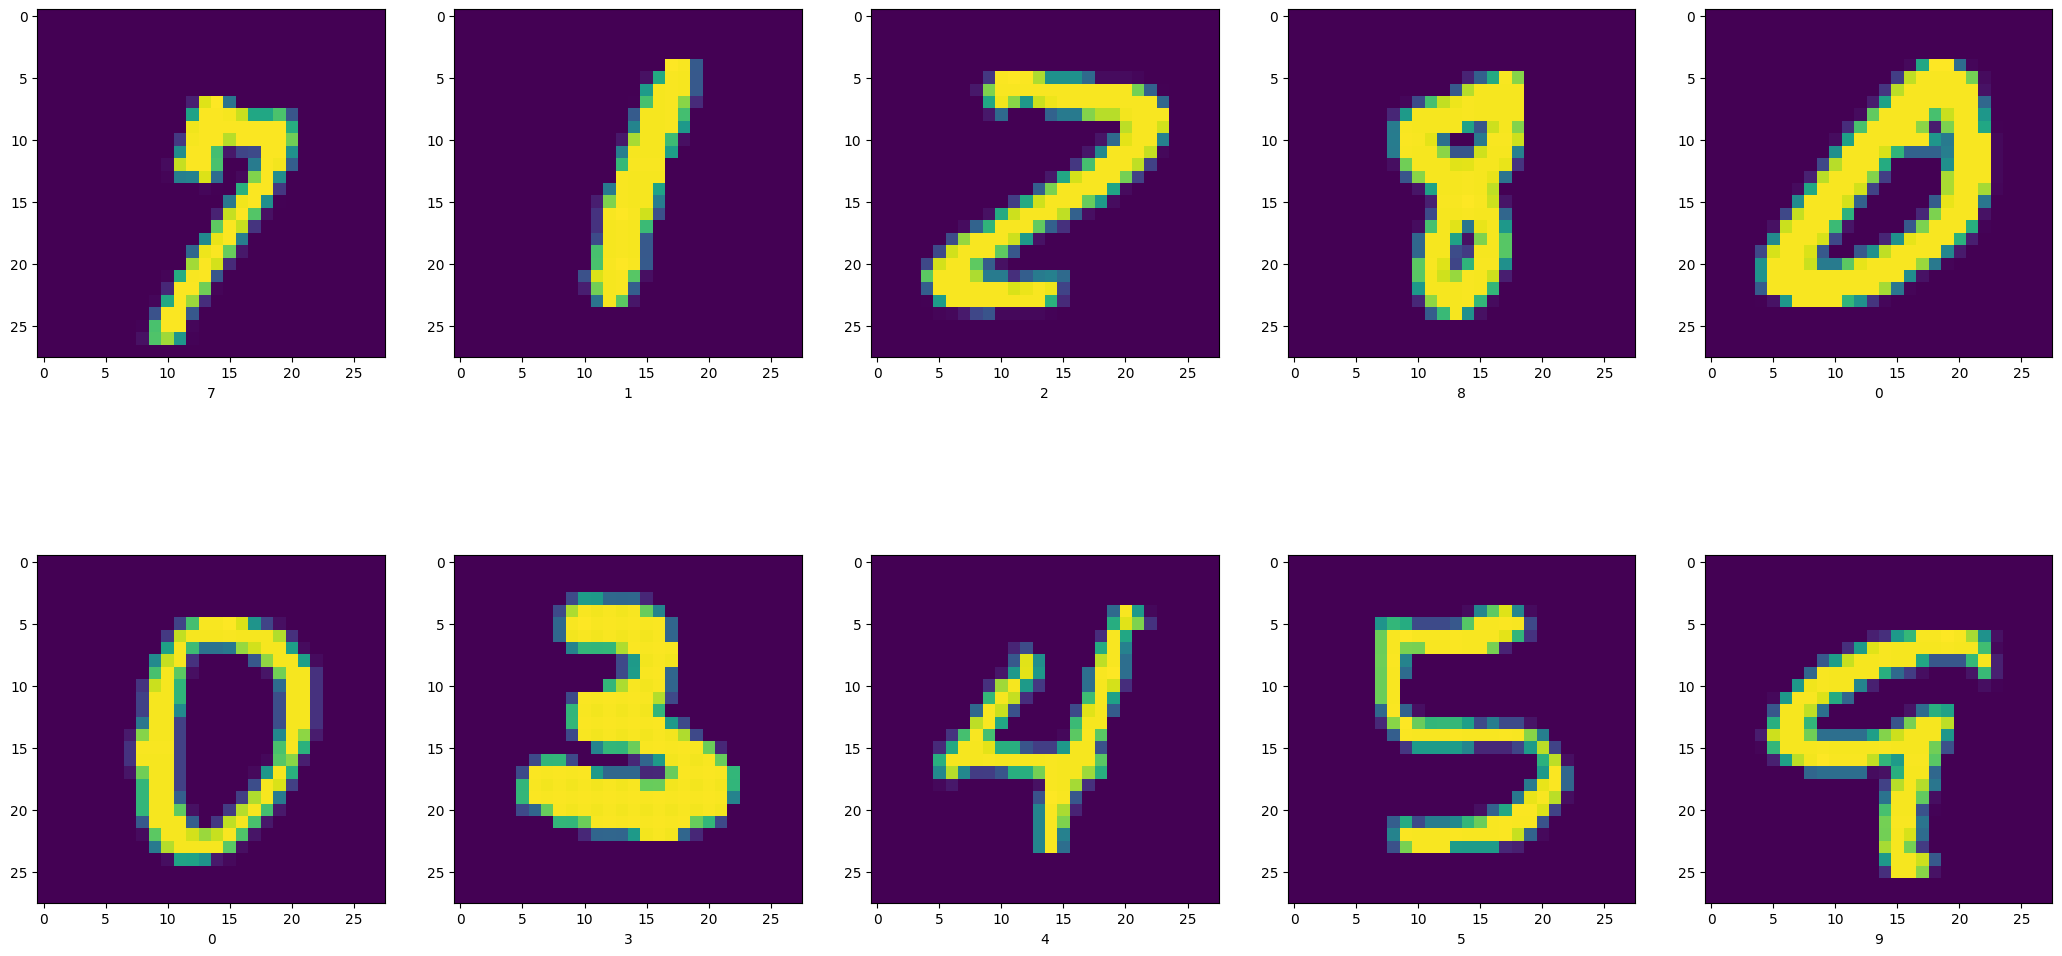

In [4]:
# Visually sampling the data

img_size = 28
columns = 5
rows = 2
fig = plt.figure(figsize=(26,13))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    random_index = random.randrange(0, len(digits))
    plt.imshow(digits[random_index].reshape(img_size, img_size))
    plt.xlabel(str(labels[random_index]))

plt.show()

#### Resizing the image

After multiple attempts at fitting the model, it was observed that the required time for the model to converge was too expensive (in one instance, it does not converge even after 2 hours). Hence it was decided to resize the number of features down to 196 (14 x 14 pixel image).

In [23]:
import cv2


digitsResized = np.zeros((len(digits), 14*14))

for i, d in enumerate(digits):
    _d = np.reshape(d, (28, 28)).astype('float32')
    resized_d = cv2.resize(_d, (14, 14))
    d_ = np.reshape(resized_d, (1, 14*14))
    digitsResized[i] = d_

# print('Digits resized', np.shape(digitsResized))

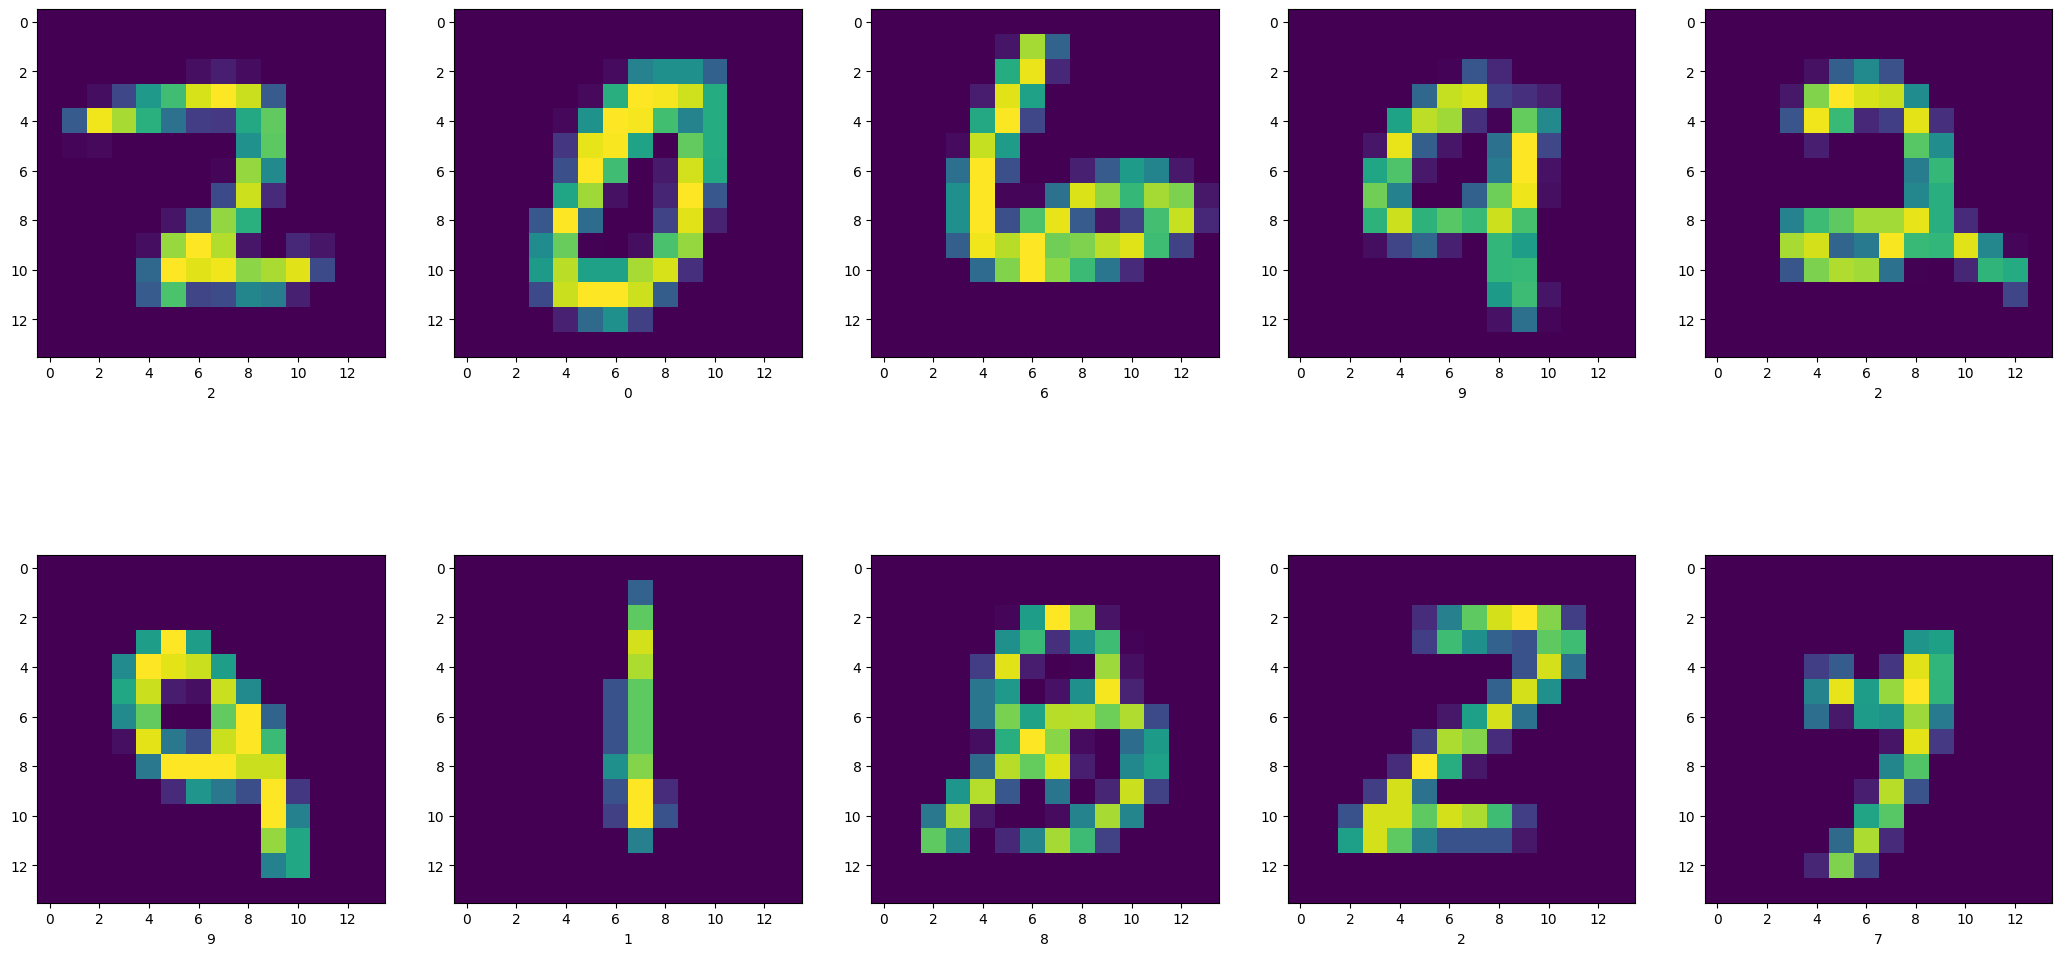

In [6]:
# Visually sampling the data

img_size = 14
columns = 5
rows = 2
fig = plt.figure(figsize=(26,13))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    random_index = random.randrange(0, len(digitsResized))
    plt.imshow(digitsResized[random_index].reshape(img_size, img_size))
    plt.xlabel(str(labels[random_index]))

plt.show()

#### Drop useless features

Useless features are those with constant values across all data points, hence cannot be used to distinguish between data.

In [24]:
def filterConstantFeature(matrix, idx):
    return False if np.var(matrix[:, idx]) == 0.0 else True


cols_digits = list(range(0, len(digits[0])))
usefulCols_digits = [filterConstantFeature(digits, i) for i in cols_digits]
digitsFiltered = digits[:, usefulCols_digits]

cols_digitsResized = list(range(0, len(digitsResized[0])))
usefulCols_digitsResized = [filterConstantFeature(digitsResized, i) for i in cols_digitsResized]
digitsResizedFiltered = digitsResized[:, usefulCols_digitsResized]     # DATA: digits -> resized to 14x14 -> dropped constant features.

print(np.shape(digitsResized))
print(np.shape(digitsResizedFiltered))

(42000, 196)
(42000, 187)


#### Splitting and scaling dataset

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train0, X_test0, y_train0, y_test0 = train_test_split(
    digitsFiltered, 
    labels, 
    train_size=5000, 
    test_size=37000, 
    random_state=1
)
X_train0_std = scaler.fit_transform(X_train0)       # Digits, filtered and scaled.
X_test0_std = scaler.transform(X_test0)


scaler = StandardScaler()
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    digitsResized, 
    labels, 
    train_size=5000, 
    test_size=37000, 
    random_state=1
)
X_train1_std = scaler.fit_transform(X_train1)       # Digits, resized and scaled.
X_test1_std = scaler.transform(X_test1)


scaler = StandardScaler()
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    digitsResizedFiltered, 
    labels, 
    train_size=5000,
    test_size=37000, 
    random_state=1
)
X_train2_std = scaler.fit_transform(X_train2)       # Digits, resized filtered and scaled.
X_test2_std = scaler.transform(X_test2)

#### End of part 1

We have prepared 3 sets of data:
- Set 0 has its constant features removed.
- Set 1 has its image dimension reduced by half.
- Set 2 has both treatments from set 0 and 1.

All sets are scaled. We are going to work mainly with set 2. Other sets are supplementary.

## Part 2: SVM parameter tuning using grid search

We are going to tune the parameters for SVC with polynomial, linear, and RBF kernels.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tqdm import tqdm


# === Note on kernels and params ===

# rbf: gamma
# linear: x, x'
# sigmoid: coef0
# poly: degree, coef0
#   but coef0 can be safely left unchanged "in most cases" according to https://stackoverflow.com/questions/21390570/scikit-learn-svc-coef0-parameter-range

paramGrid = {
    'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
    'C': [0.1, 0.5, 0.9, 1.5, 2, 2.5],
    'degree': [0.5, 1, 2, 5],
    'gamma': ['auto', 'scale'],
}

grid = GridSearchCV(SVC(), paramGrid, refit=True, verbose=3)
grid.fit(X_train2_std, y_train2)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.840 total time=   4.0s
[CV 2/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.880 total time=   2.6s
[CV 3/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.846 total time=   2.7s
[CV 4/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.858 total time=   2.8s
[CV 5/5] END C=0.1, degree=0.5, gamma=auto, kernel=rbf;, score=0.848 total time=   2.5s
[CV 1/5] END C=0.1, degree=0.5, gamma=auto, kernel=poly;, score=0.114 total time=   3.5s
[CV 2/5] END C=0.1, degree=0.5, gamma=auto, kernel=poly;, score=0.115 total time=   3.5s
[CV 3/5] END C=0.1, degree=0.5, gamma=auto, kernel=poly;, score=0.115 total time=   4.4s
[CV 4/5] END C=0.1, degree=0.5, gamma=auto, kernel=poly;, score=0.114 total time=   3.5s
[CV 5/5] END C=0.1, degree=0.5, gamma=auto, kernel=poly;, score=0.114 total time=   4.5s
[CV 1/5] END C=0.1, degree=0.5, gamma=auto, kernel=l

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 0.9, 1.5, 2, 2.5],
                         'degree': [0.5, 1, 2, 5], 'gamma': ['auto', 'scale'],
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid']},
             verbose=3)

In [10]:
from sklearn.metrics import classification_report, confusion_matrix 


print('Best estimator:', grid.best_estimator_)
print('Best params:', grid.best_params_)
print('Best score from cross-validation:', grid.best_score_)

print('\nPerformance on unseen data:')
gridPredictions = grid.predict(X_test2_std)
print(classification_report(y_test2, gridPredictions))
# print(confusion_matrix(y_test2, gridPredictions))

Best estimator: SVC(C=2.5, degree=2, kernel='poly')
Best params: {'C': 2.5, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best score from cross-validation: 0.9308

Performance on unseen data:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3651
           1       0.96      0.99      0.97      4112
           2       0.95      0.93      0.94      3674
           3       0.92      0.93      0.92      3807
           4       0.94      0.95      0.94      3582
           5       0.92      0.92      0.92      3345
           6       0.97      0.96      0.96      3656
           7       0.96      0.93      0.94      3862
           8       0.90      0.91      0.90      3592
           9       0.91      0.92      0.92      3719

    accuracy                           0.94     37000
   macro avg       0.94      0.94      0.94     37000
weighted avg       0.94      0.94      0.94     37000



In [11]:
m = SVC(kernel='poly', C=2.5, degree=2)
m.fit(X_train2_std, y_train2)
print('Accuracy on unseen data:', m.score(X_test2_std, y_test2))

Accuracy on unseen data: 0.9402702702702703


Investigate the effect of the 'coef0' parameter.

In [16]:
def showAccuracyComparisonPlot(title, xlabel, ylabel, x, y1, y2, series1, series2):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 3.5)
    fig.set_dpi(100)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.plot(x, y1, marker="o", label=series1, drawstyle="steps-post")
    ax.plot(x, y2, marker="o", label=series2, drawstyle="steps-post")
    
    ax.legend()
    plt.show()
    # fig.savefig("accuracy-decisiontree-alpha.eps", format='eps', dpi=75)

100%|██████████| 13/13 [02:20<00:00, 10.80s/it]


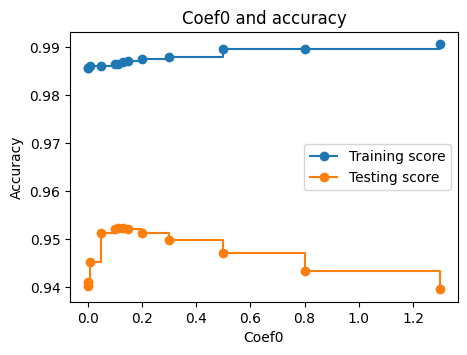

coef 0 train 0.9856 test 0.9402702702702703
coef 0.001 train 0.9856 test 0.9411621621621622
coef 0.01 train 0.9862 test 0.9453243243243243
coef 0.05 train 0.9862 test 0.9512432432432433
coef 0.1 train 0.9866 test 0.9522162162162162
coef 0.11 train 0.9866 test 0.9522702702702702
coef 0.13 train 0.987 test 0.9524324324324325
coef 0.15 train 0.9872 test 0.952081081081081
coef 0.2 train 0.9876 test 0.9514054054054054
coef 0.3 train 0.988 test 0.9498378378378378
coef 0.5 train 0.9896 test 0.9472432432432433
coef 0.8 train 0.9896 test 0.9434594594594594
coef 1.3 train 0.9906 test 0.9395675675675675


In [20]:
from tqdm import tqdm


paramCoef = [0, 0.001, 0.01, 0.05, 0.1, 0.11, 0.13, 0.15, 0.2, 0.3, 0.5, 0.8, 1.3]
trainScores = np.zeros(len(paramCoef))
testScores = np.zeros(len(paramCoef))

for i, c in enumerate(tqdm(paramCoef)):
    m = SVC(kernel='poly', C=2.5, degree=2, coef0=c)
    m.fit(X_train2_std, y_train2)

    trainScores[i] = m.score(X_train2_std, y_train2)
    testScores[i] = m.score(X_test2_std, y_test2)

showAccuracyComparisonPlot("Coef0 and accuracy", 'Coef0', 'Accuracy', paramCoef, trainScores, testScores, "Training score", "Testing score")

for i in range(len(paramCoef)):
    print(f"coef {paramCoef[i]} train {trainScores[i]} test {testScores[i]}")

It seems that 0.13 is a good value for coef0. It bumps up the accuracy on unseen data from 0.9403 to 0.9524.

## Part 3: Logistic Regression parameter tuning using grid search

We are going to tune the parameters for multinomial Logistic Regression.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


paramGrid = {
    'solver': ['liblinear', 'saga'],
    'C': [0.01, 0.1, 0.5, 1, 2],
}

grid = GridSearchCV(LogisticRegression(penalty='l1', max_iter=5000), paramGrid, refit=True, verbose=3)
grid.fit(X_train2_std, y_train2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..........C=0.01, solver=liblinear;, score=0.806 total time=   1.1s
[CV 2/5] END ..........C=0.01, solver=liblinear;, score=0.820 total time=   0.7s
[CV 3/5] END ..........C=0.01, solver=liblinear;, score=0.783 total time=   0.6s
[CV 4/5] END ..........C=0.01, solver=liblinear;, score=0.819 total time=   0.6s
[CV 5/5] END ..........C=0.01, solver=liblinear;, score=0.804 total time=   0.5s
[CV 1/5] END ...............C=0.01, solver=saga;, score=0.802 total time=  35.0s
[CV 2/5] END ...............C=0.01, solver=saga;, score=0.826 total time=  22.8s
[CV 3/5] END ...............C=0.01, solver=saga;, score=0.786 total time=  19.6s
[CV 4/5] END ...............C=0.01, solver=saga;, score=0.828 total time=  22.8s
[CV 5/5] END ...............C=0.01, solver=saga;, score=0.804 total time=  22.5s
[CV 1/5] END ...........C=0.1, solver=liblinear;, score=0.891 total time=   1.1s
[CV 2/5] END ...........C=0.1, solver=liblinear;

GridSearchCV(estimator=LogisticRegression(max_iter=5000, penalty='l1'),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 2],
                         'solver': ['liblinear', 'saga']},
             verbose=3)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix 


print('Best estimator:', grid.best_estimator_)
print('Best params:', grid.best_params_)
print('Best score from cross-validation:', grid.best_score_)

print('\nPerformance on unseen data:')
gridPredictions = grid.predict(X_test2_std)
print(classification_report(y_test2, gridPredictions))
# print(confusion_matrix(y_test2, gridPredictions))

Best estimator: LogisticRegression(C=0.5, max_iter=5000, penalty='l1', solver='saga')
Best params: {'C': 0.5, 'solver': 'saga'}
Best score from cross-validation: 0.8966

Performance on unseen data:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3651
           1       0.93      0.97      0.95      4112
           2       0.87      0.89      0.88      3674
           3       0.87      0.86      0.87      3807
           4       0.90      0.91      0.90      3582
           5       0.85      0.85      0.85      3345
           6       0.94      0.92      0.93      3656
           7       0.91      0.91      0.91      3862
           8       0.88      0.82      0.85      3592
           9       0.89      0.88      0.88      3719

    accuracy                           0.90     37000
   macro avg       0.90      0.90      0.90     37000
weighted avg       0.90      0.90      0.90     37000



In [9]:
m1 = LogisticRegression(solver='saga', C=0.1, max_iter=5000)
m2 = LogisticRegression(solver='saga', C=0.1, max_iter=5000, penalty='l1')
m3 = LogisticRegression(solver='saga', C=0.5, max_iter=5000, penalty='l1')

m1.fit(X_train2_std, y_train2)
m2.fit(X_train2_std, y_train2)
m3.fit(X_train2_std, y_train2)

print('M1 accuracy on unseen data:', m1.score(X_test2_std, y_test2))
print('M2 accuracy on unseen data:', m2.score(X_test2_std, y_test2))
print('M3 accuracy on unseen data:', m3.score(X_test2_std, y_test2))

M1 accuracy on unseen data: 0.9007027027027027
M2 accuracy on unseen data: 0.8974324324324324
M3 accuracy on unseen data: 0.8984864864864864


## Part 4: Compare performance of the two models

We are going to compare the performance of the tuned SVM model and tuned multinomial logit model.

In [21]:
from sklearn.svm import SVC


m1 = SVC(kernel='poly', C=2.5, degree=2)
m2 = LogisticRegression(solver='saga', C=0.5, max_iter=5000, penalty='l1')
m1_op = SVC(kernel='poly', C=2.5, degree=2, coef0=0.13)

m1.fit(X_train2_std, y_train2)
m2.fit(X_train2_std, y_train2)
m1_op.fit(X_train2_std, y_train2)

print('SVC accuracy on unseen data:', m1.score(X_test2_std, y_test2))
print('SVC with coef0 0.13 accuracy on unseen data:', m1_op.score(X_test2_std, y_test2))
print('Multinomial Logit accuracy on unseen data:', m2.score(X_test2_std, y_test2))

SVC accuracy on unseen data: 0.9402702702702703
SVC with coef0 0.13 accuracy on unseen data: 0.9524324324324325
Multinomial Logit accuracy on unseen data: 0.8984864864864864


## Part 5: Statistical test to see if there is any difference

In [25]:
scaler = StandardScaler()

for i in range(10):

    xtrain, xtest, ytrain, ytest = train_test_split(
        digitsResizedFiltered, 
        labels, 
        train_size=37800,
        test_size=4200, 
        random_state=i
    )
    xtrain_std = scaler.fit_transform(xtrain)       # Digits, resized filtered and scaled.
    xtest_std = scaler.transform(xtest)

    m1 = SVC(kernel='poly', C=2.5, degree=2, coef0=0.13).fit(xtrain_std, ytrain)
    m2 = LogisticRegression(solver='saga', C=0.5, max_iter=5000, penalty='l1').fit(xtrain_std, ytrain)

    print(f"SVC {m1.score(xtest_std, ytest)} Logreg {m2.score(xtest_std, ytest)}")    

SVC 0.9704761904761905 Logreg 0.9245238095238095


In [4]:
from mlxtend.evaluate import mcnemar
import numpy as np


tb_b = np.array([
    [8985, 0],
    [539, 476]
])

chi2, p = mcnemar(ary=tb_b, corrected=True)
print('chi-squared:', chi2)
print('p-value:', p)

# chi squared critical value at 1df and .05 significance level is 3.84
# our chi squared is 537.002 > 3.84
# thus we reject null hypothesis

chi-squared: 537.0018552875696
p-value: 8.465953884840993e-119
